In [1]:
#for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

In [2]:
path = r"/Users/acyang@us.ibm.com/Desktop/Wafer-Spacial-Analysis/FlowerImages/flower_images/flower_images"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
flowers = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the flowers list
            flowers.append(file.name)

In [3]:
# load the image as a 224x224 array
img = load_img(flowers[0], target_size=(224,224))
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)

print(img.shape)
(224, 224, 3)

(224, 224, 3)


(224, 224, 3)

In [4]:
reshaped_img = img.reshape(1,224,224,3)
print(reshaped_img.shape)
#(num_of_samples, rows, columns, rgb)
(1, 224, 224, 3)

(1, 224, 224, 3)


(1, 224, 224, 3)

In [5]:
x = preprocess_input(reshaped_img)

In [6]:
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [7]:
image = load_img(flowers[0], target_size=(224,224))
image = img.reshape(1,224,224,3)
image = preprocess_input(image)
features = model.predict(image)
print(features.shape)
(1,4096)

(1, 4096)


(1, 4096)

In [8]:
features

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [10]:
data = {}
p = r"/Users/acyang@us.ibm.com/Desktop/Wafer-Spacial-Analysis/FlowerImages/flower_features.pkl"

# lop through each image in the dataset
for flower in flowers:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(flower,model)
        data[flower] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)
          
 
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
feat.shape
(210, 1, 4096)

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)
feat.shape
(210, 4096)

# get the unique labels (from the flower_labels.csv)
df = pd.read_csv('flower_labels.csv')
label = df['label'].tolist()
unique_labels = list(set(label))

In [11]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [12]:
# cluster feature vectors
kmeans = KMeans(n_clusters=len(unique_labels),n_jobs=-1, random_state=22)
kmeans.fit(x)

/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


KMeans(n_clusters=10, n_jobs=-1, random_state=22)

In [13]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [14]:
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

In [15]:
# this is just incase you want to see which value for k might be the best 
sse = []
list_k = list(range(3, 50))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22, n_jobs=-1)
    km.fit(x)
    
    sse.append(km.inertia_)

/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/usr/local/lib/python3.9/sit

/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/usr/local/lib/python3.9/sit

In [16]:
sse

[637089.125,
 593087.6875,
 565975.25,
 547461.875,
 527877.8125,
 511194.21875,
 504965.5,
 488679.8125,
 476251.5625,
 470936.1875,
 462163.15625,
 447133.90625,
 447363.6875,
 439828.96875,
 434399.90625,
 423182.1875,
 416458.21875,
 411381.28125,
 402814.6875,
 397632.5,
 392998.53125,
 389734.3125,
 372516.21875,
 374031.5,
 370860.65625,
 358672.4375,
 359952.125,
 356071.15625,
 344816.15625,
 345197.5625,
 342960.875,
 339710.5,
 331248.03125,
 329714.65625,
 323151.21875,
 319419.5,
 318050.9375,
 311853.90625,
 306591.59375,
 300666.15625,
 301304.25,
 298984.625,
 290732.75,
 290500.59375,
 282653.90625,
 279591.9375,
 273560.03125]

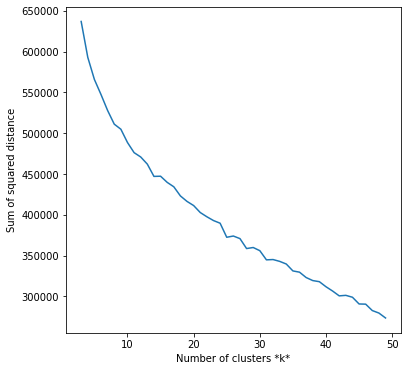

In [16]:
# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [17]:
groups

{4: ['0065.png',
  '0110.png',
  '0058.png',
  '0067.png',
  '0073.png',
  '0116.png',
  '0076.png',
  '0128.png',
  '0114.png',
  '0204.png',
  '0012.png',
  '0013.png',
  '0207.png',
  '0005.png',
  '0038.png',
  '0004.png',
  '0010.png',
  '0160.png',
  '0001.png',
  '0017.png',
  '0002.png',
  '0147.png',
  '0185.png',
  '0030.png',
  '0018.png',
  '0187.png',
  '0186.png',
  '0008.png',
  '0181.png',
  '0143.png',
  '0209.png',
  '0044.png',
  '0084.png',
  '0042.png',
  '0137.png',
  '0041.png',
  '0055.png',
  '0120.png',
  '0054.png',
  '0068.png',
  '0097.png'],
 2: ['0071.png',
  '0059.png',
  '0111.png',
  '0104.png',
  '0066.png',
  '0115.png',
  '0075.png',
  '0198.png',
  '0007.png',
  '0011.png',
  '0158.png',
  '0170.png',
  '0028.png',
  '0161.png',
  '0203.png',
  '0176.png',
  '0033.png',
  '0144.png',
  '0019.png',
  '0025.png',
  '0182.png',
  '0154.png',
  '0020.png',
  '0034.png',
  '0194.png',
  '0037.png',
  '0093.png',
  '0078.png',
  '0124.png',
  '0131.png',

Clipping cluster size from 35 to 30


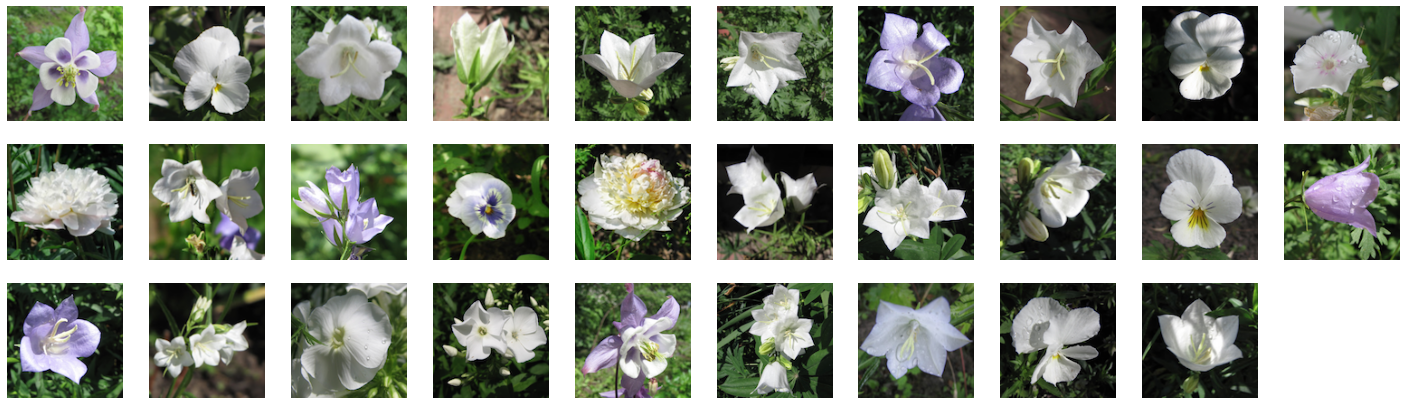

In [19]:
view_cluster(2)